In [6]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
import xarray as xr
import numpy as np
import pandas as pd
import calendar
import seaborn as sns
import seaborn_image as isns
import calendar
import string

In [7]:
import plotly.io as pio
pio.renderers.default='jupyterlab'

In [8]:
plt.style.use('seaborn-pastel')
isns.set_context(mode="notebook", fontfamily="Times")
sns.set_context(font_scale=0.8)

In [9]:
base_eu_26 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/CO2flux/co2flux_baseline_2.6_weighted.nc', decode_times=True)
oae_eu_26 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/CO2flux/co2flux_oae_2.6_weighted.nc', decode_times=True)

base_eu_70 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP3_7.0/CO2flux/co2flux_baseline_7.0_weighted.nc', decode_times=True)
oae_eu_70 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP3_7.0/CO2flux/co2flux_oae_7.0_weighted.nc', decode_times=True)

base_dp_26 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/CO2flux/CO2flux_Baseline_2.6_cropped.nc', decode_times=True)
oae_dp_26 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/CO2flux/CO2flux_OAE_2.6_cropped.nc', decode_times=True)

base_dp_70 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP3_7.0/CO2flux/CO2flux_Baseline_7.0_cropped.nc', decode_times=True)
oae_dp_70 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP3_7.0/CO2flux/CO2flux_OAE_7.0_cropped.nc', decode_times=True)

In [10]:
datasets = [base_dp_26, oae_dp_26, base_dp_70, oae_dp_70]

In [11]:
newsets = []

for dataset in datasets:
    dataset = dataset.where((3 < dataset.nav_lon) & (dataset.nav_lon < 3.1) & (52 < dataset.nav_lat) & (dataset.nav_lat < 53), drop=True)
    newsets.append(dataset)

In [12]:
datadict = {
    'base_dp_26' : newsets[0],
    'oae_dp_26' : newsets[1],
    'base_dp_70' : newsets[2],
    'oae_dp_70' : newsets[3]
}

In [13]:
class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = mpatches.Ellipse(xy=center, width=height + xdescent,
                             height=height + ydescent)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

In [14]:
def annualavg(co2flux):
    co2flux = co2flux.sel(time_counter=slice('2090','2100'))
    co2flux = (co2flux.co2flux * 31536000 / 0.04401) # kg/m2/yr CO2
    co2flux = co2flux.sel(time=0).drop('time').to_dataset(name='co2flux')
    month_length_baseline = co2flux.time_counter.dt.days_in_month
    co2flux = ((co2flux * month_length_baseline).resample(time_counter='M').sum() / month_length_baseline.resample(time_counter='M').sum()).to_dataframe()
    co2flux = (co2flux.groupby(co2flux.index.month).mean()).reset_index()
    co2flux['time_counter'] = co2flux['time_counter'].apply(lambda x: calendar.month_abbr[x])
    return(co2flux)

In [15]:
def annualavg_dp(co2flux):
    co2flux = co2flux.sel(time_counter=slice('2090','2100'))
    co2flux = ((co2flux.co2flux.mean(dim=('x','y'))) * 31536000 / 0.04401) # kg/m2/yr CO2
    co2flux = co2flux.sel(time=0).drop('time').to_dataset(name='co2flux')
    month_length_baseline = co2flux.time_counter.dt.days_in_month
    co2flux = ((co2flux * month_length_baseline).resample(time_counter='M').sum() / month_length_baseline.resample(time_counter='M').sum()).to_dataframe()
    co2flux = (co2flux.groupby(co2flux.index.month).mean()).reset_index()
    co2flux['time_counter'] = co2flux['time_counter'].apply(lambda x: calendar.month_abbr[x])
    return(co2flux)

In [16]:
def comp(oae, baseline):
    baseline = baseline.set_index('time_counter')
    oae = oae.set_index('time_counter')
    delta = (oae.co2flux - baseline.co2flux).to_xarray().to_dataframe('co2flux').reset_index()
    return(delta)

In [17]:
def fig(base, oae, delta, axTop, axBot):
    axTop.plot(base.co2flux, '-', color="black", linewidth=0.5, zorder=1)
    axTop.plot(oae.co2flux, '-', color="black", linewidth=0.5, zorder=1)
    axTop.scatter(base.time_counter, base.co2flux, color=base.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)
    axTop.scatter(oae.time_counter, oae.co2flux, color=oae.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)
    axBot.plot(delta.co2flux, '-', color="black", linewidth=0.5, zorder=1)
    axBot.scatter(delta.time_counter, delta.co2flux, color=delta.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)
    axTop.tick_params(axis='y', which='major', labelsize=12)

In [18]:
base_eu_26 = annualavg(base_eu_26)
oae_eu_26 = annualavg(oae_eu_26)
base_eu_70 = annualavg(base_eu_70)
oae_eu_70 = annualavg(oae_eu_70)

In [23]:
base_dp_26 = annualavg_dp(datadict['base_dp_26'])
oae_dp_26 = annualavg_dp(datadict['oae_dp_26'])
base_dp_70 = annualavg_dp(datadict['base_dp_70'])
oae_dp_70 = annualavg_dp(datadict['oae_dp_70'])

In [24]:
delta_mean_eu_26 = comp(oae_eu_26, base_eu_26)
delta_mean_eu_70 = comp(oae_eu_70, base_eu_70)
delta_mean_dp_26 = comp(oae_dp_26, base_dp_26)
delta_mean_dp_70 = comp(oae_dp_70, base_dp_70)

In [25]:
colors_month_co2flux = dict(zip(base_eu_26.time_counter.unique(), 
                                ['powderblue', 'darkcyan', 'forestgreen', 'darkseagreen', 
                                 'honeydew', 'bisque', 'khaki', 'gold', 
                                 'sandybrown', 'lightcoral', 'chocolate', 'cadetblue']))

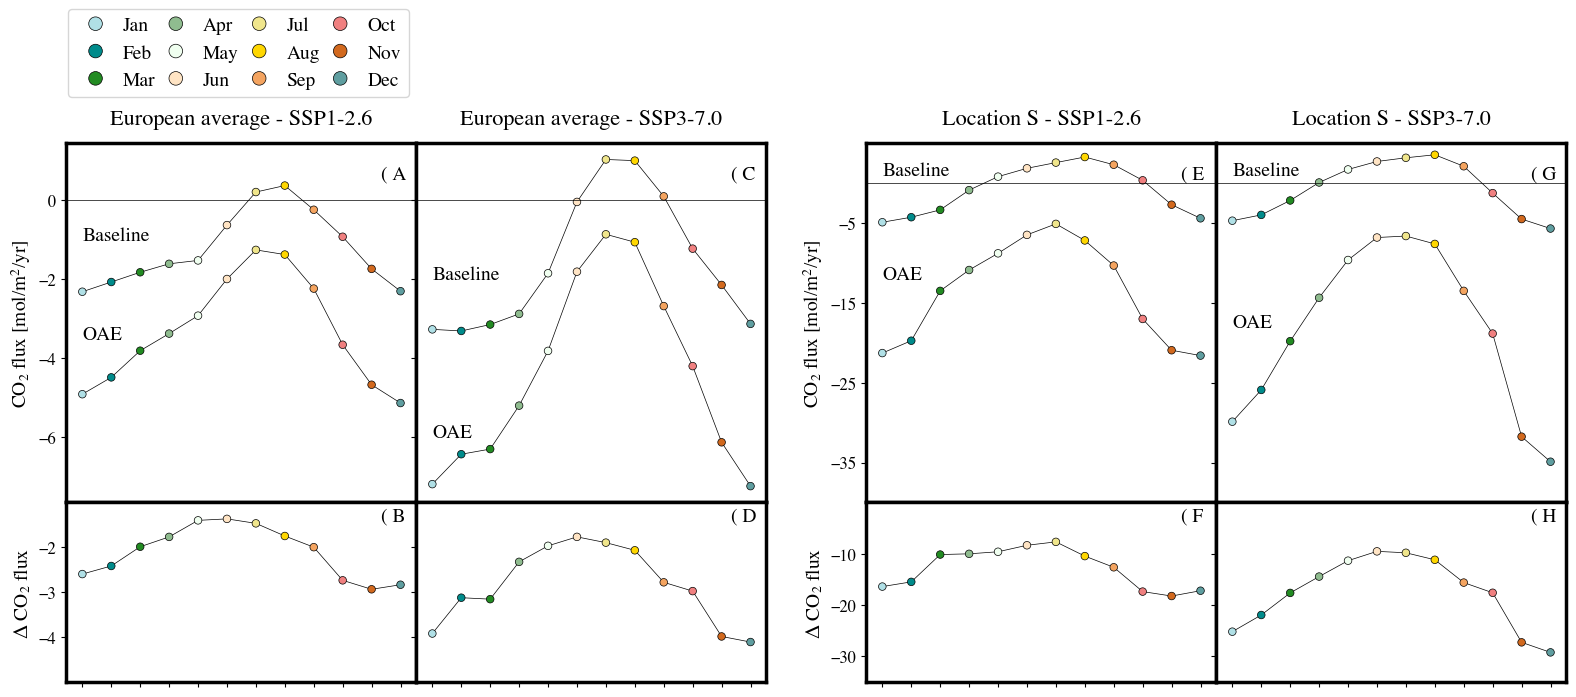

In [29]:
f = plt.figure(figsize=(20, 7)) 
gs_left = f.add_gridspec(nrows=2, ncols=4, height_ratios=[2, 1])
gs_right = f.add_gridspec(nrows=2, ncols=4, height_ratios=[2, 1])

ax1 = plt.subplot(gs_left[0,0])
ax2 = plt.subplot(gs_left[1,0])
ax3 = plt.subplot(gs_left[0,1], sharey = ax1)
ax4 = plt.subplot(gs_left[1,1], sharey = ax2)
ax5 = plt.subplot(gs_right[0,2])
ax6 = plt.subplot(gs_right[1,2])
ax7 = plt.subplot(gs_right[0,3], sharey = ax5)
ax8 = plt.subplot(gs_right[1,3], sharey = ax6)

gs_left.update(wspace=0, hspace=0, left=0, right=0.7)
gs_right.update(wspace=0, hspace=0, left=0.05, right=0.75)

fig(base_eu_26, oae_eu_26, delta_mean_eu_26, ax1, ax2)
fig(base_eu_70, oae_eu_70, delta_mean_eu_70, ax3, ax4)
fig(base_dp_26, oae_dp_26, delta_mean_dp_26, ax5, ax6)
fig(base_dp_70, oae_dp_70, delta_mean_dp_70, ax7, ax8)

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

for ax in axes:
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.tick_params(axis='y', which='major', labelsize=12)
    if ax == ax1 or ax == ax5:
        ax.set_ylabel('$\mathregular{CO_{2}}$ flux $\mathregular{[mol/m^2/yr]}$', fontsize=14)
    if ax == ax2 or ax == ax6:
        ax.set_ylabel('Δ $\mathregular{CO_{2}}$ flux', fontsize=14)
    if ax == ax3 or ax == ax4 or ax == ax7 or ax == ax8:
        ax.yaxis.set_tick_params(labelleft=False)
    if ax == ax1 or ax == ax3 or ax == ax5 or ax == ax7:
        ax.axhline(0, color='black', linewidth=0.5)
for n, ax in enumerate(axes):
    ax.text(0.9, 0.9, string.punctuation[7] + ' ' + string.ascii_uppercase[n], transform=ax.transAxes, 
            size=14, weight='bold', color='black')

ax1.text(0, -1, s='Baseline', fontsize=14)
ax1.text(0, -3.5, s='OAE', fontsize=14)
ax3.text(0, -2, s='Baseline', fontsize=14)
ax3.text(0, -6, s='OAE', fontsize=14)
ax5.text(0, 1, s='Baseline', fontsize=14)
ax5.text(0, -12, s='OAE', fontsize=14)
ax7.text(0, 1, s='Baseline', fontsize=14)
ax7.text(0, -18, s='OAE', fontsize=14)

start2, end2 = ax2.set_ylim(-5, -1)
ax2.yaxis.set_ticks(np.arange(start2+1, end2, 1))
start5, end5 = ax5.set_ylim(-40, 5)
ax5.yaxis.set_ticks(np.arange(start5+5, end5, 10))
start6, end6 = ax6.set_ylim(-35, 0)
ax6.yaxis.set_ticks(np.arange(start6+5, end6, 10))

ax1.set_title("European average - SSP1-2.6", fontsize=16, y=1.03)
ax3.set_title("European average - SSP3-7.0", fontsize=16, y=1.03)
ax5.set_title("Location S - SSP1-2.6", fontsize=16, y=1.03)
ax7.set_title("Location S - SSP3-7.0", fontsize=16, y=1.03)

legend = [mpatches.Circle((0.5, 0.5), 1, facecolor = value, edgecolor = "black", linewidth=0.5, label = key, alpha = 1) for key, value in colors_month_co2flux.items()]
ax.legend(handles = legend, bbox_to_anchor=(-2.28,3.8), loc='best', columnspacing=0.05, handletextpad=0.4, fontsize=14, ncol = 4, handler_map={mpatches.Circle: HandlerEllipse()})

plt.savefig('/Users/chiaraciscato/Desktop/geomar/geomarcode/seasonal_analysis/final_figs/co2flux.png')